In [13]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



In [14]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final=pd.read_sql_query(""" SELECT * FROM Reviews""", conn) 

In [15]:
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
# Sorting data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final= final.sort_values(by = "Time")


In [16]:
from sklearn.model_selection import train_test_split
X = final["CleanedText"]
y = final["Score"].map(lambda x: 1 if x == 'positive' else 0)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle='false')
print(X_train.shape, y_train.shape, x_test.shape)

(61442,) (61442,) (26333,)


In [17]:
bow = CountVectorizer(binary=True)
X_train = bow.fit_transform(X_train)
X_train
x_test = bow.transform(x_test)
x_test.shape
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
from sklearn.preprocessing import StandardScaler
X_train=StandardScaler(with_mean=False).fit_transform(X_train)
x_test=StandardScaler(with_mean=False).fit_transform(x_test)


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, make_scorer

clf = DecisionTreeClassifier()
#params we need to try on classifier
param_grid = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]}


tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Auc score: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  2.3min finished


Best HyperParameter:  {'max_depth': 16}
Best Auc score: 74.61%


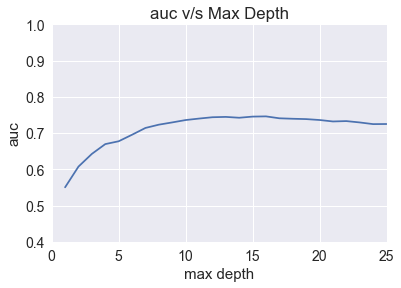

In [19]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,25)
plt.ylim(0.4,1)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("auc")
plt.title(r'auc v/s Max Depth')
plt.plot(x,y)
plt.show()


The accuracy of the lr for c = 10 is 86.082102%

The f1 score of the lr for c = 10 is 64.131430%

The recall score of the lr for c = 10 is 61.128262%

The precision score of the lr for c = 10 is 79.103793%


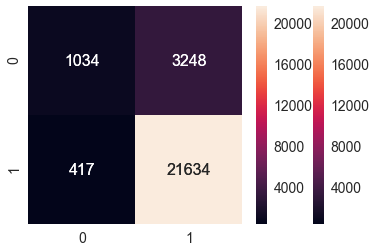

In [24]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf =  DecisionTreeClassifier(max_depth=13)
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the lr for c = %d is %f%%' % (10, acc))
print('\nThe f1 score of the lr for c = %d is %f%%' % (10, f1))
print('\nThe recall score of the lr for c = %d is %f%%' % (10, r))
print('\nThe precision score of the lr for c = %d is %f%%' % (10, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


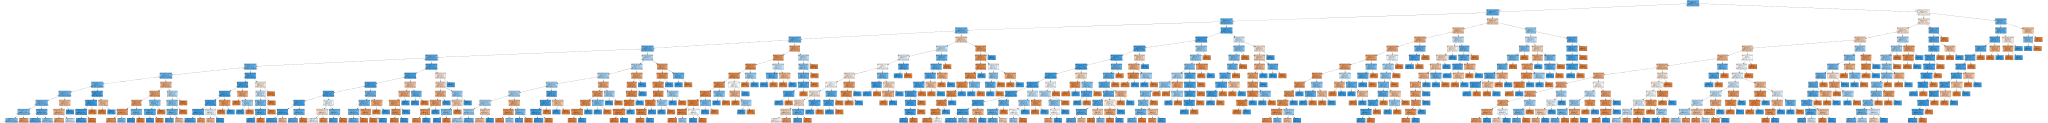

In [25]:
 
from sklearn import tree
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
graph = Source(tree.export_graphviz(clf, out_file=None 
   , filled = True))
display(SVG(graph.pipe(format='svg')))


In [21]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier



clf = DecisionTreeClassifier()
param_grid = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Auc: %.2f%%"%(gsv.best_score_*100))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   48.0s finished


Best HyperParameter:  {'max_depth': 14}
Best Auc: 74.53%


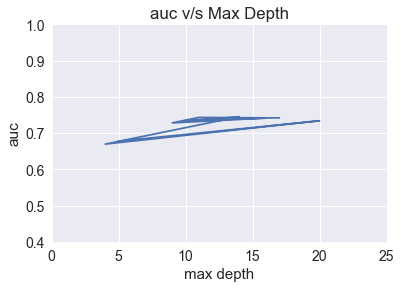

In [26]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,25)
plt.ylim(0.4,1)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("auc")
plt.title(r'auc v/s Max Depth')
plt.plot(x,y)
plt.show()


The accuracy of the lr for c = 10 is 86.070710%

The f1 score of the lr for c = 10 is 63.763101%

The recall score of the lr for c = 10 is 60.820361%

The precision score of the lr for c = 10 is 79.468174%


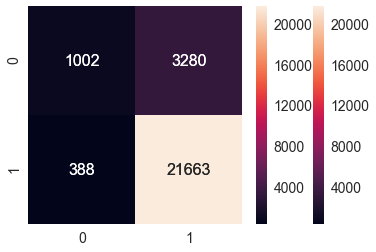

In [27]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf =  DecisionTreeClassifier(max_depth=12)
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the lr for c = %d is %f%%' % (10, acc))
print('\nThe f1 score of the lr for c = %d is %f%%' % (10, f1))
print('\nThe recall score of the lr for c = %d is %f%%' % (10, r))
print('\nThe precision score of the lr for c = %d is %f%%' % (10, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


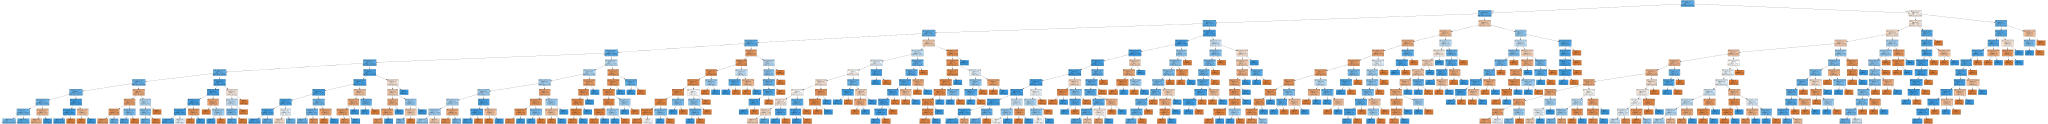

In [28]:
 
from sklearn import tree
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
graph = Source(tree.export_graphviz(clf, out_file=None 
   , filled = True))
display(SVG(graph.pipe(format='svg')))


In [29]:
X = final["CleanedText"]
y = final["Score"].map(lambda x: 1 if x == 'positive' else 0)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42,shuffle='false')
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)
x_test = tf_idf_vect.transform(x_test)



(61442,) (26333,) (61442,) (26333,)


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, make_scorer

clf = DecisionTreeClassifier()
#params we need to try on classifier
param_grid = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]}


tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Auc score: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  3.2min finished


Best HyperParameter:  {'max_depth': 15}
Best Auc score: 74.37%


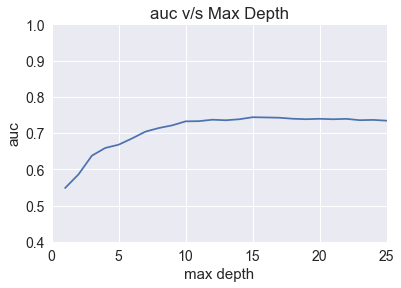

In [31]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,25)
plt.ylim(0.4,1)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("auc")
plt.title(r'auc v/s Max Depth')
plt.plot(x,y)
plt.show()


The accuracy of the lr for c = 10 is 85.664375%

The f1 score of the lr for c = 10 is 62.804013%

The recall score of the lr for c = 10 is 60.154323%

The precision score of the lr for c = 10 is 77.338786%


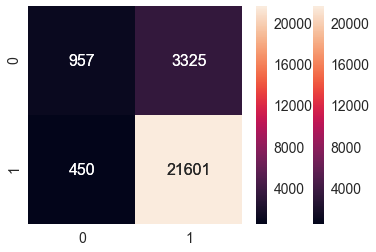

In [32]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf =  DecisionTreeClassifier(max_depth=14)
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the lr for c = %d is %f%%' % (10, acc))
print('\nThe f1 score of the lr for c = %d is %f%%' % (10, f1))
print('\nThe recall score of the lr for c = %d is %f%%' % (10, r))
print('\nThe precision score of the lr for c = %d is %f%%' % (10, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

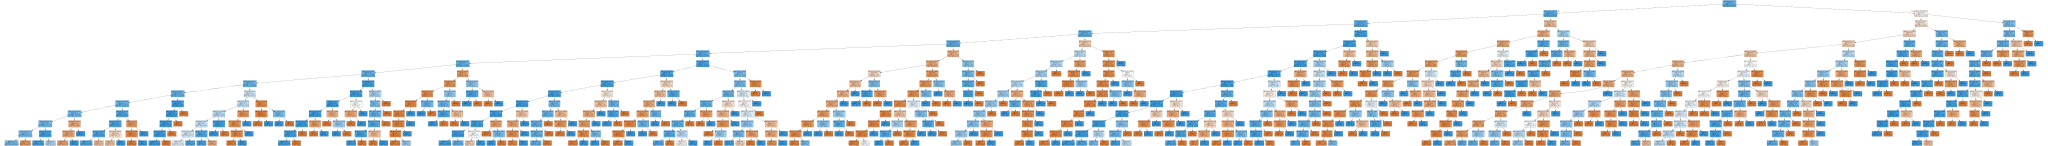

In [33]:
 
from sklearn import tree
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
graph = Source(tree.export_graphviz(clf, out_file=None 
   , filled = True))
display(SVG(graph.pipe(format='svg')))


In [34]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier



clf = DecisionTreeClassifier()
param_grid = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Auc score: %.2f%%"%(gsv.best_score_*100))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.6min finished


Best HyperParameter:  {'max_depth': 19}
Best Auc score: 74.12%


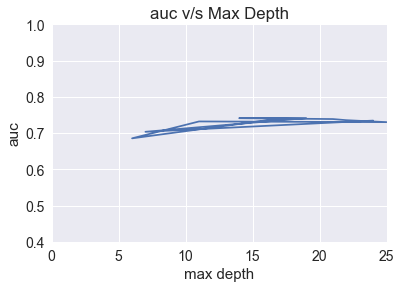

In [35]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,25)
plt.ylim(0.4,1)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("auc")
plt.title(r'auc v/s Max Depth')
plt.plot(x,y)
plt.show()


The accuracy of the lr for c = 10 is 85.622603%

The f1 score of the lr for c = 10 is 62.712908%

The recall score of the lr for c = 10 is 60.091743%

The precision score of the lr for c = 10 is 77.115756%


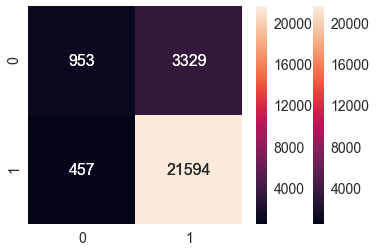

In [36]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf =  DecisionTreeClassifier(max_depth=14)
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the lr for c = %d is %f%%' % (10, acc))
print('\nThe f1 score of the lr for c = %d is %f%%' % (10, f1))
print('\nThe recall score of the lr for c = %d is %f%%' % (10, r))
print('\nThe precision score of the lr for c = %d is %f%%' % (10, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')


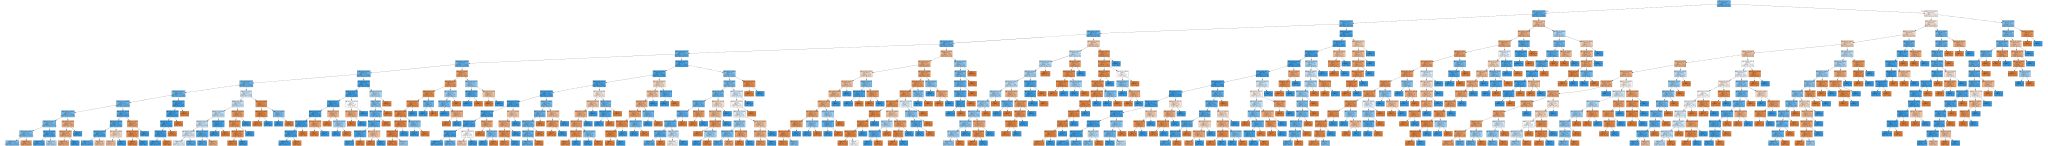

In [37]:
 
from sklearn import tree
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
graph = Source(tree.export_graphviz(clf, out_file=None 
   , filled = True))
display(SVG(graph.pipe(format='svg')))


In [38]:
X = final["CleanedText"]
y = final["Score"].map(lambda x: 1 if x == 'positive' else 0)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42,shuffle='false')

In [39]:
list_of_sent=[]
#for sent in final_40k['Text'].values:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)    

In [40]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [41]:
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

61442
50
26333
50


In [42]:
from sklearn import preprocessing
X_train = sent_vectors
x_test = sent_vectors_test
X_train = preprocessing.normalize(X_train)
x_test = preprocessing.normalize(x_test)

In [43]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier



clf = DecisionTreeClassifier()
param_grid = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Auc score: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  2.1min finished


Best HyperParameter:  {'max_depth': 7}
Best Auc score: 80.28%


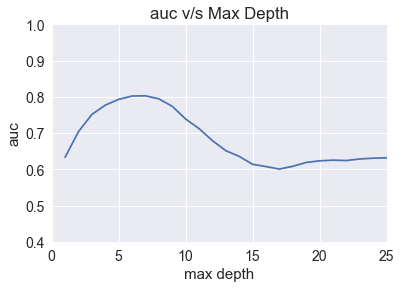

In [44]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,25)
plt.ylim(0.4,1)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("auc")
plt.title(r'auc v/s Max Depth')
plt.plot(x,y)
plt.show()


The accuracy of the lr for c = 10 is 85.820074%

The f1 score of the lr for c = 10 is 66.685050%

The recall score of the lr for c = 10 is 63.672280%

The precision score of the lr for c = 10 is 75.434577%


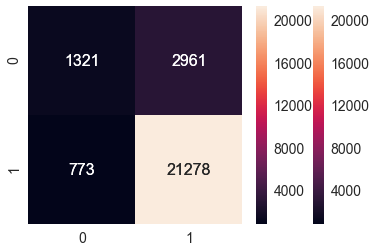

In [45]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf =  DecisionTreeClassifier(max_depth=6)
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the lr for c = %d is %f%%' % (10, acc))
print('\nThe f1 score of the lr for c = %d is %f%%' % (10, f1))
print('\nThe recall score of the lr for c = %d is %f%%' % (10, r))
print('\nThe precision score of the lr for c = %d is %f%%' % (10, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

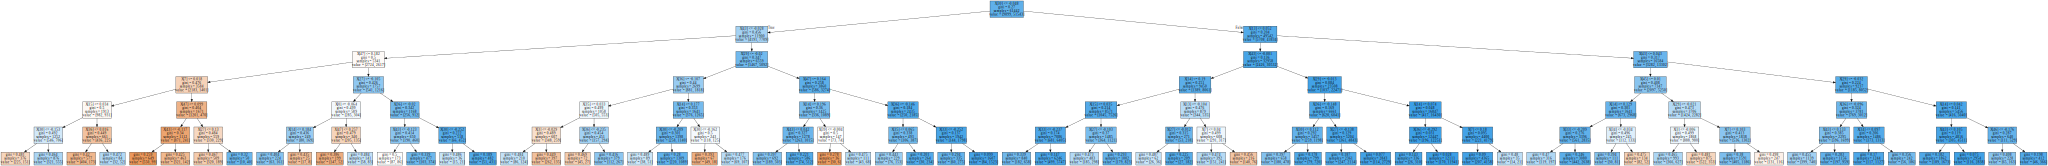

In [46]:
 
from sklearn import tree
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
graph = Source(tree.export_graphviz(clf, out_file=None 
   , filled = True))
display(SVG(graph.pipe(format='svg')))


In [47]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier



clf = DecisionTreeClassifier()
param_grid = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Auc score: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   59.5s finished


Best HyperParameter:  {'max_depth': 7}
Best Auc score: 80.28%


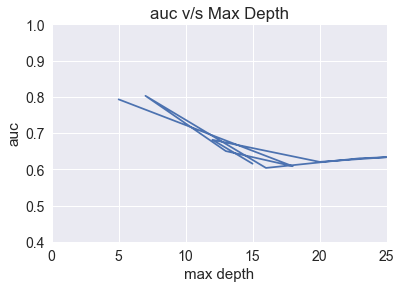

In [48]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,25)
plt.ylim(0.4,1)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("auc")
plt.title(r'auc v/s Max Depth')
plt.plot(x,y)
plt.show()


The accuracy of the lr for c = 10 is 85.413739%

The f1 score of the lr for c = 10 is 68.423652%

The recall score of the lr for c = 10 is 65.941948%

The precision score of the lr for c = 10 is 73.322968%


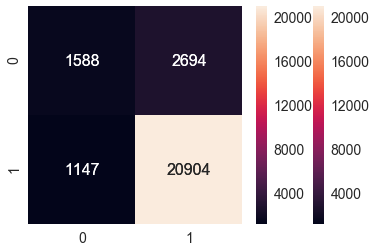

In [49]:
#Testing Accuracy on Test data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf =  DecisionTreeClassifier(max_depth=9)
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the lr for c = %d is %f%%' % (10, acc))
print('\nThe f1 score of the lr for c = %d is %f%%' % (10, f1))
print('\nThe recall score of the lr for c = %d is %f%%' % (10, r))
print('\nThe precision score of the lr for c = %d is %f%%' % (10, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

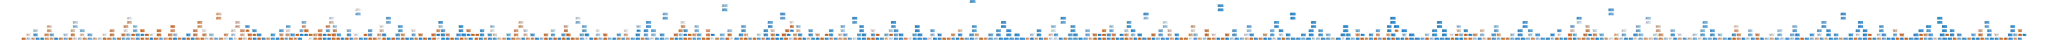

In [50]:
 
from sklearn import tree
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
graph = Source(tree.export_graphviz(clf, out_file=None 
   , filled = True))
display(SVG(graph.pipe(format='svg')))


In [51]:
X = final["CleanedText"]
y = final["Score"].map(lambda x: 1 if x == 'positive' else 0)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42,shuffle='false')
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61442,) (26333,) (61442,) (26333,)


In [52]:
tf_idf_vect = TfidfVectorizer()


In [53]:
X_train = tf_idf_vect.fit_transform(X_train)
x_test = tf_idf_vect.transform(x_test)

In [54]:

w2v_words = list(w2v_model.wv.vocab)
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  
X_train = tfidf_sent_vectors    
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1  

In [55]:
X_train = tfidf_sent_vectors

In [56]:
x_test = tfidf_sent_vectors_test
X_train = np.nan_to_num(X_train)
x_test = np.nan_to_num(x_test)

In [57]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier



clf = DecisionTreeClassifier()
param_grid = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = GridSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Auc : %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  2.0min finished


Best HyperParameter:  {'max_depth': 7}
Best Auc : 76.86%


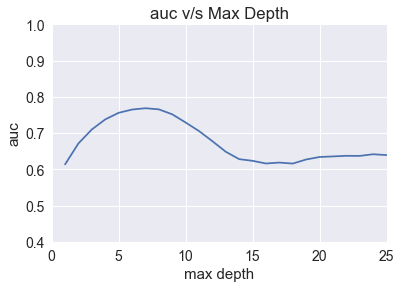

In [58]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,25)
plt.ylim(0.4,1)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("auc")
plt.title(r'auc v/s Max Depth')
plt.plot(x,y)
plt.show()


The accuracy of the lr for c = 10 is 84.604868%

The f1 score of the lr for c = 10 is 59.787545%

The recall score of the lr for c = 10 is 58.006799%

The precision score of the lr for c = 10 is 72.198230%


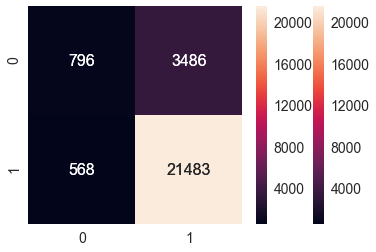

In [62]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf =  DecisionTreeClassifier(max_depth=5)
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the lr for c = %d is %f%%' % (10, acc))
print('\nThe f1 score of the lr for c = %d is %f%%' % (10, f1))
print('\nThe recall score of the lr for c = %d is %f%%' % (10, r))
print('\nThe precision score of the lr for c = %d is %f%%' % (10, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

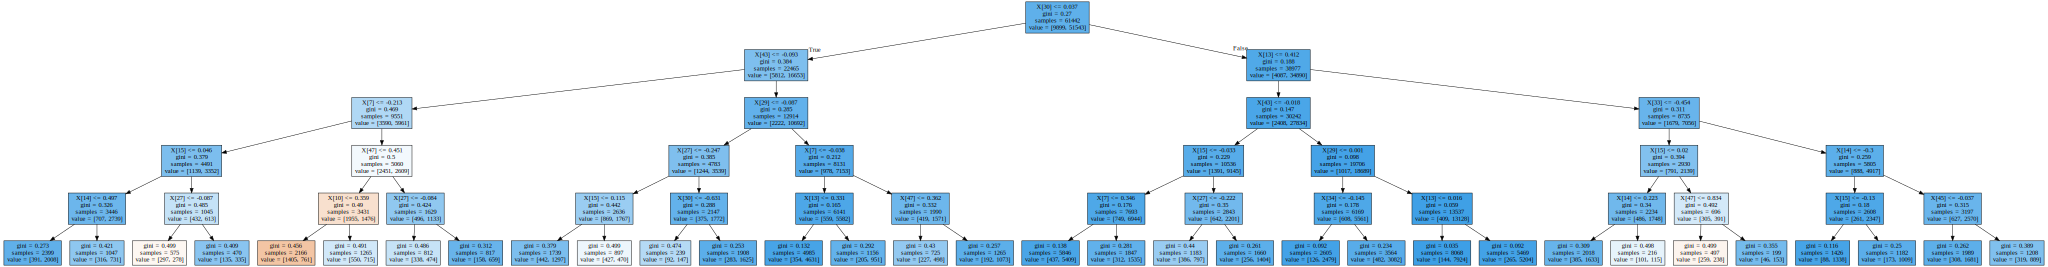

In [63]:
 
from sklearn import tree
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
graph = Source(tree.export_graphviz(clf, out_file=None 
   , filled = True))
display(SVG(graph.pipe(format='svg')))


In [64]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier



clf = DecisionTreeClassifier()
param_grid = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
gsv = RandomizedSearchCV(clf,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Auc score: %.2f%%"%(gsv.best_score_*100))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   52.4s finished


Best HyperParameter:  {'max_depth': 8}
Best Auc score: 76.53%


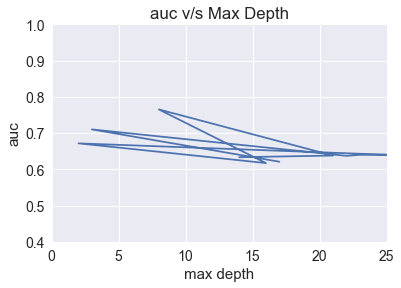

In [65]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['max_depth']) 
    y.append(a[1])
plt.xlim(0,25)
plt.ylim(0.4,1)
plt.xlabel(r"max depth",fontsize=15)
plt.ylabel("auc")
plt.title(r'auc v/s Max Depth')
plt.plot(x,y)
plt.show()


The accuracy of the lr for c = 10 is 84.604868%

The f1 score of the lr for c = 10 is 59.787545%

The recall score of the lr for c = 10 is 58.006799%

The precision score of the lr for c = 10 is 72.198230%


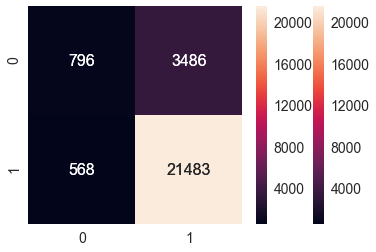

In [66]:
#Testing Accuracy on Test data
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
clf =  DecisionTreeClassifier(max_depth=5)
clf.fit(X_train,y_train)
pred = clf.predict(x_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
f1=f1_score(y_test, pred,average= 'macro')*100
r=recall_score(y_test, pred,average= 'macro')*100
p=precision_score(y_test, pred,average= 'macro')*100
    

print('\nThe accuracy of the lr for c = %d is %f%%' % (10, acc))
print('\nThe f1 score of the lr for c = %d is %f%%' % (10, f1))
print('\nThe recall score of the lr for c = %d is %f%%' % (10, r))
print('\nThe precision score of the lr for c = %d is %f%%' % (10, p))
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

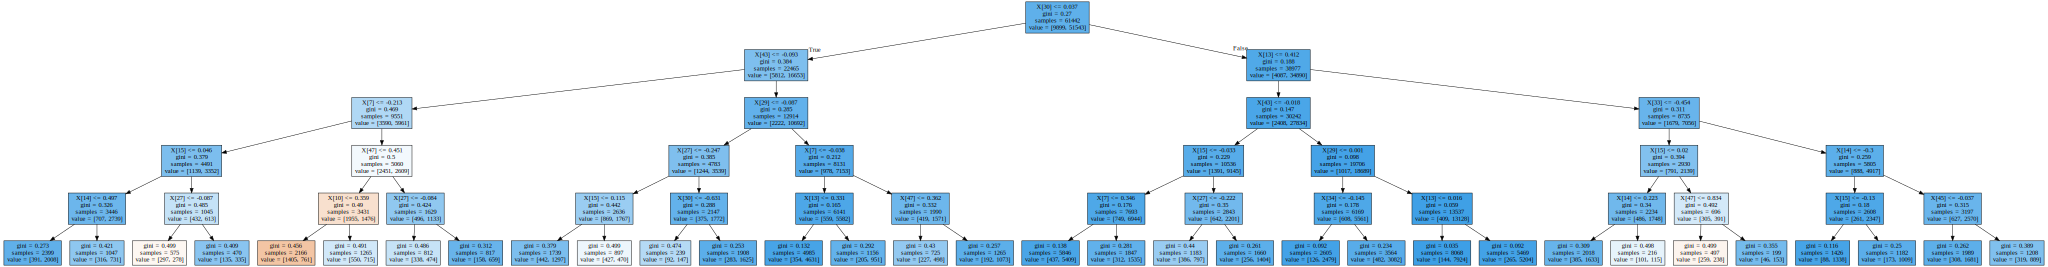

In [67]:
 
from sklearn import tree
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')
import graphviz
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
graph = Source(tree.export_graphviz(clf, out_file=None 
   , filled = True))
display(SVG(graph.pipe(format='svg')))


In [68]:
import sys
sys.path.append('c://users/melvi/appdata/local/programs/python/python36/lib/site-packages')

from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Max depth", "accuracy", "f1 score","recall","precision score"]
x.add_row(["BOW", 13,90.26,81.40,79.91,83.19])
x.add_row(["RANDOM SEARCH BOW", 12,90.28,81.46,79.98,83.22])
x.add_row(["TFIDF", 16,91.13,82.58,80.19,85.73])
x.add_row(["RANDOM SEARCH TFIDF",15,91.13,82.58,80.19,85.73])
x.add_row(["AVGW2V", 6,86.54,70.39,67.21,77.44])
x.add_row(["RANDOM SEARCH AVGW2V", 9,86.52,70.32,67.13,77.43])
x.add_row(["TFIDFW2V", 7, 83.43,45.48,50.00,41.71])
x.add_row(["RANDOM SEARCH TFIDFW2V", 7, 83.43,45.48,50.00,41.71])
print(x)


+------------------------+-----------+----------+----------+--------+-----------------+
|         Model          | Max depth | accuracy | f1 score | recall | precision score |
+------------------------+-----------+----------+----------+--------+-----------------+
|          BOW           |     13    |  90.26   |   81.4   | 79.91  |      83.19      |
|   RANDOM SEARCH BOW    |     12    |  90.28   |  81.46   | 79.98  |      83.22      |
|         TFIDF          |     16    |  91.13   |  82.58   | 80.19  |      85.73      |
|  RANDOM SEARCH TFIDF   |     15    |  91.13   |  82.58   | 80.19  |      85.73      |
|         AVGW2V         |     6     |  86.54   |  70.39   | 67.21  |      77.44      |
|  RANDOM SEARCH AVGW2V  |     9     |  86.52   |  70.32   | 67.13  |      77.43      |
|        TFIDFW2V        |     7     |  83.43   |  45.48   |  50.0  |      41.71      |
| RANDOM SEARCH TFIDFW2V |     7     |  83.43   |  45.48   |  50.0  |      41.71      |
+------------------------+------